# Visualisation of WSIs normalisation

Environment: basic server's `Python 3.8.10` environment.

In this notebook I'm simply going to visualise the results of the normalisation methods applied to the WSI.\
The normalisation scripts can be found in the different `./scripts_for_sATAC_WSIs/WSI_normaliser_<METHOD_NAME>.py` files. The reason of this is the time taken for the computations as it can get up to 6 hours!

For facilitaing the launch of the scripts, in the `WSI_launching_scripts.sh` file you can find all the `nohup` based commands, which will let the scripts run even after disconnecting from the server.

---

Given all the **normalisation methods** that I've tried:
-   Staintools:
    -   Macenko
    -   Reinahrd
    -   Vahadane
-   HistomicsTK:
    -   Macenko with masking
    -   Macenko without masking  
    -   Reinhard with masking
    -   Reinhard without masking
-   StainGAN 
    -   Model A
    -   Model B
-   StainNET
-   TorchVahadane
   
and the **target images** (if necessary), only a few of them worked, mainly due to the big size of the images that made the computations crash every time I was trying to run the code.

So, here I'm going to show the results of the ones that were successfully computed.

# 0. - Imports and paths

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import squidpy as sq
import pandas as pd
import anndata as ad
import os
import sys
import subprocess
from PIL import Image
import random
pd.options.mode.chained_assignment = None

In [2]:
# setting the working directory
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/0_WSI_alignment_and_normalisation/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/0_WSI_alignment_and_normalisation


# 1. - Visualisation

Out of all the initial methods, only the HistomicsTK ones worked, so here we are going to visualise the results and compare them with the original WSI.

1. Original WSI' size:

In [3]:
# Imports
ORIGINAL_WSI_PATH = '../data/spatial_atac/modified_images/BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling.jpg'

# open the image without pixels limits and store the size (pixel, pixel)
Image.MAX_IMAGE_PIXELS = None
full_res_image = Image.open(ORIGINAL_WSI_PATH)
image_size = full_res_image.size
print(f"The WSI is {image_size[0]} by {image_size[1]} pixels")

The WSI is 47616 by 48128 pixels


2. Normalised WSIs and eventual masks

In [4]:
def normalisation_paths(base_dir, wsi_name):
    '''
    Returns a Pandas DataFrame containing the computed normalisation methods, the target name and the relative path of the image.
    '''
    # Initialize a list to hold the data for the DataFrame
    data = []
        
    # Walk through the directory structure
    for root, dirs, files in os.walk(base_dir):
        # Filter .jpg files
        for f in files:
            if f.lower().endswith(".jpg"):
                # Parse normalization method and target from the directory structure
                relative_path = os.path.relpath(root, base_dir)
                path_parts = relative_path.split(os.sep)

                # Initialize variables
                normalization_method = path_parts[0] if len(path_parts) >= 1 else None
                is_mask = True if f.startswith("mask") else False
                target = "-"

                # Check for specific targets or models in deeper paths
                if len(path_parts) > 1:
                    if path_parts[1].startswith("target"):
                        target = path_parts[1]
                    elif path_parts[1].startswith("model"):
                        normalization_method = f"{normalization_method}_{path_parts[1]}"

                # Add the data row if a normalization method is valid
                if normalization_method:
                    data.append({
                        "Normalization Method": normalization_method,
                        "Target": target,
                        "Mask": is_mask,
                        #"Size": str(f.size[0]) + "x" + str(f.size[1]) + " pixels",
                        "Path to folder": relative_path + "/" + f # path to the final folder as well
                        })

    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # Optionally, sort the DataFrame for better readability
    df = df.sort_values(by=["Normalization Method", 
                            "Target"]).reset_index(drop=True)
    
    return df

In [5]:
WSI_NORMALISATION_OUTPUT_PATH = "./output/sATAC_C1/wsi_v3/"
print(os.listdir(WSI_NORMALISATION_OUTPUT_PATH))

['staintools_reinhard', 'torch_vahadane_gpu', 'torch_vahadane_cpu', 'staintools_macenko', 'staintools_vahadane', 'stainNET', 'stainGAN', 'histomicsTK_reinhard_nomasking', 'histomicsTK_reinhard_withmasking', 'histomicsTK_macenko_nomasking', 'histomicsTK_macenko_withmasking', 'resized_high_res_original_BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling.png', 'normalisation_summary.csv']


In [6]:
df_normalised_wsi = normalisation_paths(WSI_NORMALISATION_OUTPUT_PATH, os.path.basename(ORIGINAL_WSI_PATH)[:5])
# saving the dataframe for simplicity when working with the paths. Next cell takes 5 mins to run
df_normalised_wsi.to_csv(f"{WSI_NORMALISATION_OUTPUT_PATH}/normalisation_summary.csv", header=True, index= False)

df_normalised_wsi

,Normalization Method,Target,Mask,Path to folder
0,histomicsTK_macenko_nomasking,target_is_reference_full,False,histomicsTK_macenko_nomasking/target_is_refere...
1,histomicsTK_macenko_withmasking,target_is_reference_full,False,histomicsTK_macenko_withmasking/target_is_refe...
2,histomicsTK_macenko_withmasking,target_is_reference_full,True,histomicsTK_macenko_withmasking/target_is_refe...
3,histomicsTK_reinhard_nomasking,target_is_default,False,histomicsTK_reinhard_nomasking/target_is_defau...
4,histomicsTK_reinhard_nomasking,target_is_reference_full,False,histomicsTK_reinhard_nomasking/target_is_refer...
5,histomicsTK_reinhard_withmasking,target_is_default,False,histomicsTK_reinhard_withmasking/target_is_def...
6,histomicsTK_reinhard_withmasking,target_is_default,True,histomicsTK_reinhard_withmasking/target_is_def...
7,histomicsTK_reinhard_withmasking,target_is_reference_full,False,histomicsTK_reinhard_withmasking/target_is_ref...
8,histomicsTK_reinhard_withmasking,target_is_reference_full,True,histomicsTK_reinhard_withmasking/target_is_ref...
9,staintools_reinhard,target_is_reference_full,False,staintools_reinhard/target_is_reference_full/B...


Let's check the size of the normalised images, just to make sure that the normalisation procedure worked correctly.

In [7]:
def image_size(row):
    if not row[2]:
        temp_image = Image.open(os.path.join(WSI_NORMALISATION_OUTPUT_PATH, row[3]))
        return temp_image.size

all_wsi_sizes = df_normalised_wsi.apply(image_size, axis=1)
all_wsi_sizes

0    (47616, 48128)
1    (47616, 48128)
2              None
3    (47616, 48128)
4    (47616, 48128)
5    (47616, 48128)
6              None
7    (47616, 48128)
8              None
9    (47616, 48128)
dtype: object

Yes, they are all the same.

## 1.1 - Deriving a high-resolution image from WSI
Considering the size of the WSI, to simplify it's visualisation in the notebook, let's create an high resolution version of the image.\
Looking at other high resolution images obtained from other Visium analysis, After reviewing other high-resolution images from Visium analyses, I’ve chosen a **width of 2000 pixels**—this appears to be the standard scaled width for high-resolution images.
The first step will be to derive the height of the image. The calculus is a simple proportion:

\[
\frac{\text{old\_width}}{\text{new\_width}} = \frac{\text{old\_height}}{\text{new\_height}}
\]

Rearranging to solve for *new_height*:

\[
\text{new\_height} = \frac{\text{new\_width} \times \text{old\_height}}{\text{old\_width}}
\]

Using this formula, you can easily calculate the new height based on the original dimensions and the desired width.

Let's scale them

In [8]:
width_in_pixels = 2000
os.makedirs("./figures", exist_ok=True)  # Ensure the directory exists

# looping over every path of the normalised WSI
for i in df_normalised_wsi.iloc[:, -1]:
    # joining path with the output folder
    path_to_image = os.path.join(WSI_NORMALISATION_OUTPUT_PATH, i)
    
    # open the image, calculate the width and perform the resizing
    full_res_image = Image.open(path_to_image)
    
    height_in_pixels = round((full_res_image.size[1] * width_in_pixels / full_res_image.size[0]))
    new_size = width_in_pixels, height_in_pixels
    
    high_res_image = full_res_image.resize(new_size, Image.Resampling.LANCZOS) # real resizing step
    
    # saving image in PNG format
    high_res_image_name = "resized_high_res_" + os.path.basename(i).split(".")[0]
    high_res_png_path = os.path.join(os.path.dirname(path_to_image), f"{high_res_image_name}.png")
    high_res_image.save(high_res_png_path, "PNG")
    
    # saving image in PDF format
    high_res_pdf_path = os.path.join("./figures", f"{high_res_image_name}.pdf")
    high_res_image.save(high_res_pdf_path, "PDF")


# For the original WSI
full_res_image = Image.open(ORIGINAL_WSI_PATH)
height_in_pixels = round((full_res_image.size[1] * width_in_pixels) / full_res_image.size[0])
new_size = (width_in_pixels, height_in_pixels)

high_res_image = full_res_image.resize(new_size, Image.Resampling.LANCZOS)

# Saving
original_png_path = os.path.join(WSI_NORMALISATION_OUTPUT_PATH, f"resized_high_res_original_{os.path.basename(ORIGINAL_WSI_PATH).split('.')[0]}.png")
high_res_image.save(original_png_path, "PNG")
original_pdf_path = os.path.join("./figures", f"resized_high_res_original_{os.path.basename(ORIGINAL_WSI_PATH).split('.')[0]}.pdf")
high_res_image.save(original_pdf_path, "PDF")

In [9]:
RESIZED_ORIGINAL_WSI = [i for i in os.listdir(WSI_NORMALISATION_OUTPUT_PATH) if i.startswith("resized")]
print(RESIZED_ORIGINAL_WSI[0])
resized_wsi_size = Image.open(os.path.join(WSI_NORMALISATION_OUTPUT_PATH, f"{RESIZED_ORIGINAL_WSI[0]}")).size
print(f"The new image will be: {resized_wsi_size[0]} x {resized_wsi_size[1]} pixels.")

resized_high_res_original_BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling.png
The new image will be: 2000 x 2022 pixels.


After rescaling, let's visualise them.

In [10]:
# list for all the paths to the scaled files
all_resize_paths = [os.path.join(root, i) for root, _, files in os.walk(WSI_NORMALISATION_OUTPUT_PATH) for i in files if i.startswith("resized")]
#all_resize_paths_dict = {i: os.path.join(root, i) for root, _, files in os.walk(WSI_NORMALISATION_OUTPUT_PATH) for i in files if i.startswith("resized")}
print(f"In total, we have {len(all_resize_paths)} resized images.")
all_resize_paths
#all_resize_paths_dict

In total, we have 11 resized images.


['./output/sATAC_C1/wsi_v3/resized_high_res_original_BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling.png',
 './output/sATAC_C1/wsi_v3/staintools_reinhard/target_is_reference_full/resized_high_res_BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling_st_reinhard_normalized.png',
 './output/sATAC_C1/wsi_v3/histomicsTK_reinhard_nomasking/target_is_default/resized_high_res_BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling_histomicsTK_reinhard_nomasking.png',
 './output/sATAC_C1/wsi_v3/histomicsTK_reinhard_nomasking/target_is_reference_full/resized_high_res_BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling_histomicsTK_reinhard_nomasking.png',
 './output/sATAC_C1/wsi_v3/histomicsTK_reinhard_withmasking/target_is_default/resized_high_res_BCSA4_A2_sATAC_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling_histomicsTK_reinhard_withmasking.png',
 './output/sATAC_

And create lists containing the paths to the files to facilitate the next steps.

In [11]:
all_resized_masks = [i for i in all_resize_paths if "_mask_" in i]
all_resized_wsis = [i for i in all_resize_paths if i not in all_resized_masks]
all_resized_masks
# for i in all_resize_paths:
#     plt.imshow(tissue_rgb)
#     plt.title("Original Image")
#     plt.show()

['./output/sATAC_C1/wsi_v3/histomicsTK_reinhard_withmasking/target_is_default/resized_high_res_mask_reinhard_wsi.png',
 './output/sATAC_C1/wsi_v3/histomicsTK_reinhard_withmasking/target_is_reference_full/resized_high_res_mask_reinhard_wsi.png',
 './output/sATAC_C1/wsi_v3/histomicsTK_macenko_withmasking/target_is_reference_full/resized_high_res_mask_macenko_wsi.png']

## 1.2 - Visualising the results
Here I'm going to show the results of the normalisation processes.

### 1.2.1 - Comparison of normalised WSIs 

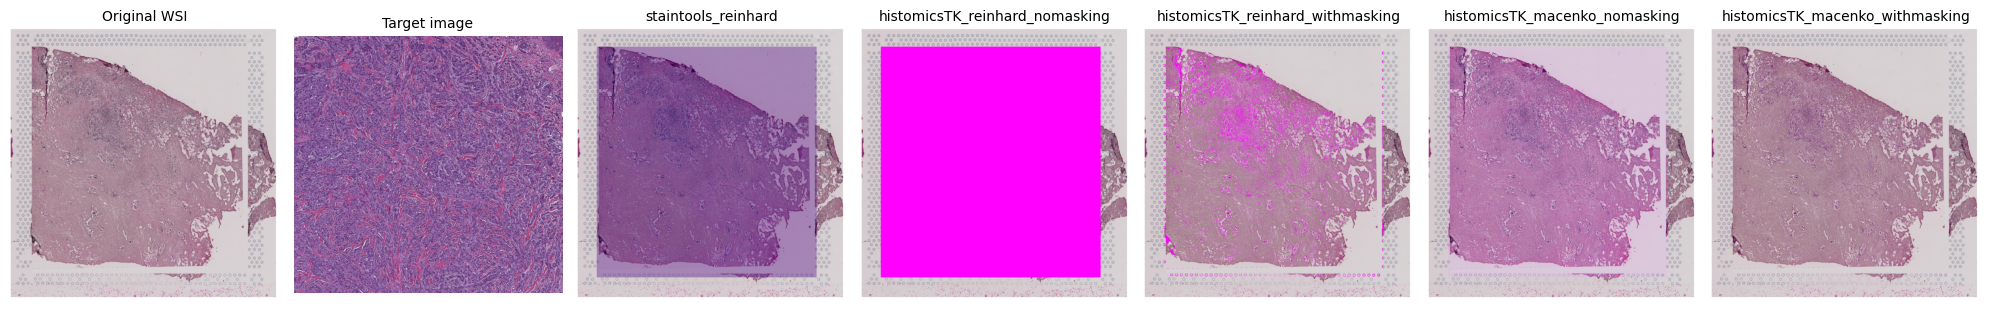

In [12]:
# If we want to plot only the WSI normalised with the image `reference_full.jpeg`
TARGET_IS_REFERENCE = "target_is_reference_full"
temp_resized_wsis_reference = []
for i in all_resized_wsis:
    parts = i.split("/")
    if len(parts) > 5 and parts[5] == TARGET_IS_REFERENCE:
        temp_resized_wsis_reference.append(i)

# adding the path to the original image
temp_resized_wsis_reference.insert(0, all_resized_wsis[0])

# adding the path to the target image
PATH_TO_REFERENCE = "../2_image_normalisation/reference_images/reference_full.jpeg"
temp_resized_wsis_reference.insert(1, PATH_TO_REFERENCE)
#print(temp_resized_wsis_reference)

# Number of rows and columns for the grid
n_rows, n_cols = 1, len(temp_resized_wsis_reference)

# Create a figure, axes amd font size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows*20, n_cols*20))
font = 10

# Plot each image
for i, ax in enumerate(axes.flat):
    if i < len(temp_resized_wsis_reference):
        
        # Setting the titles of the image
        if temp_resized_wsis_reference[i] == PATH_TO_REFERENCE: 
            # case 1: target image
            target = Image.open(temp_resized_wsis_reference[i])
            
            # resizing for displaying IT DOESN'T WORK!!
            width_in_pixels = round((target.size[1] * height_in_pixels) / target.size[0])
            new_size = (width_in_pixels, height_in_pixels)
            #print(new_size)
            resized_target = target.resize(new_size, Image.Resampling.LANCZOS)
            
            ax.imshow(resized_target) 
            ax.set_title(f"Target image", fontsize=font)
            
        else:            
            
            if "original" in os.path.basename(temp_resized_wsis_reference[i]): 
                # case 2: original WSI
                img = mpimg.imread(temp_resized_wsis_reference[i])
                ax.imshow(img) 
                ax.set_title(f"Original WSI", fontsize=font)
                
            else:
                # case 3: normalised images: title after normalisation method
                title = temp_resized_wsis_reference[i].split("/")[-3]
                img = mpimg.imread(temp_resized_wsis_reference[i])
                ax.imshow(img)
                ax.set_title(f"{title}", fontsize=font) 
    ax.axis("off")  # Hide the axis

# Adjust layout
plt.tight_layout()
fig.savefig("./figures/comparison_of_methods_reference_full.pdf", format="pdf", bbox_inches="tight")
fig.savefig("./figures/comparison_of_methods_reference_full.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


As we can see from the results:
-   Reinhard's method doesn't work properly with WSI, even when we use a different package (obviously, the algorithm doesn't change). However, it seems to be better when masking, but in the end it's still biased.
-   Macenko's method works in both the cases, and in particular, here we can see the effect of the masking!  

Let's also visualise the masks!

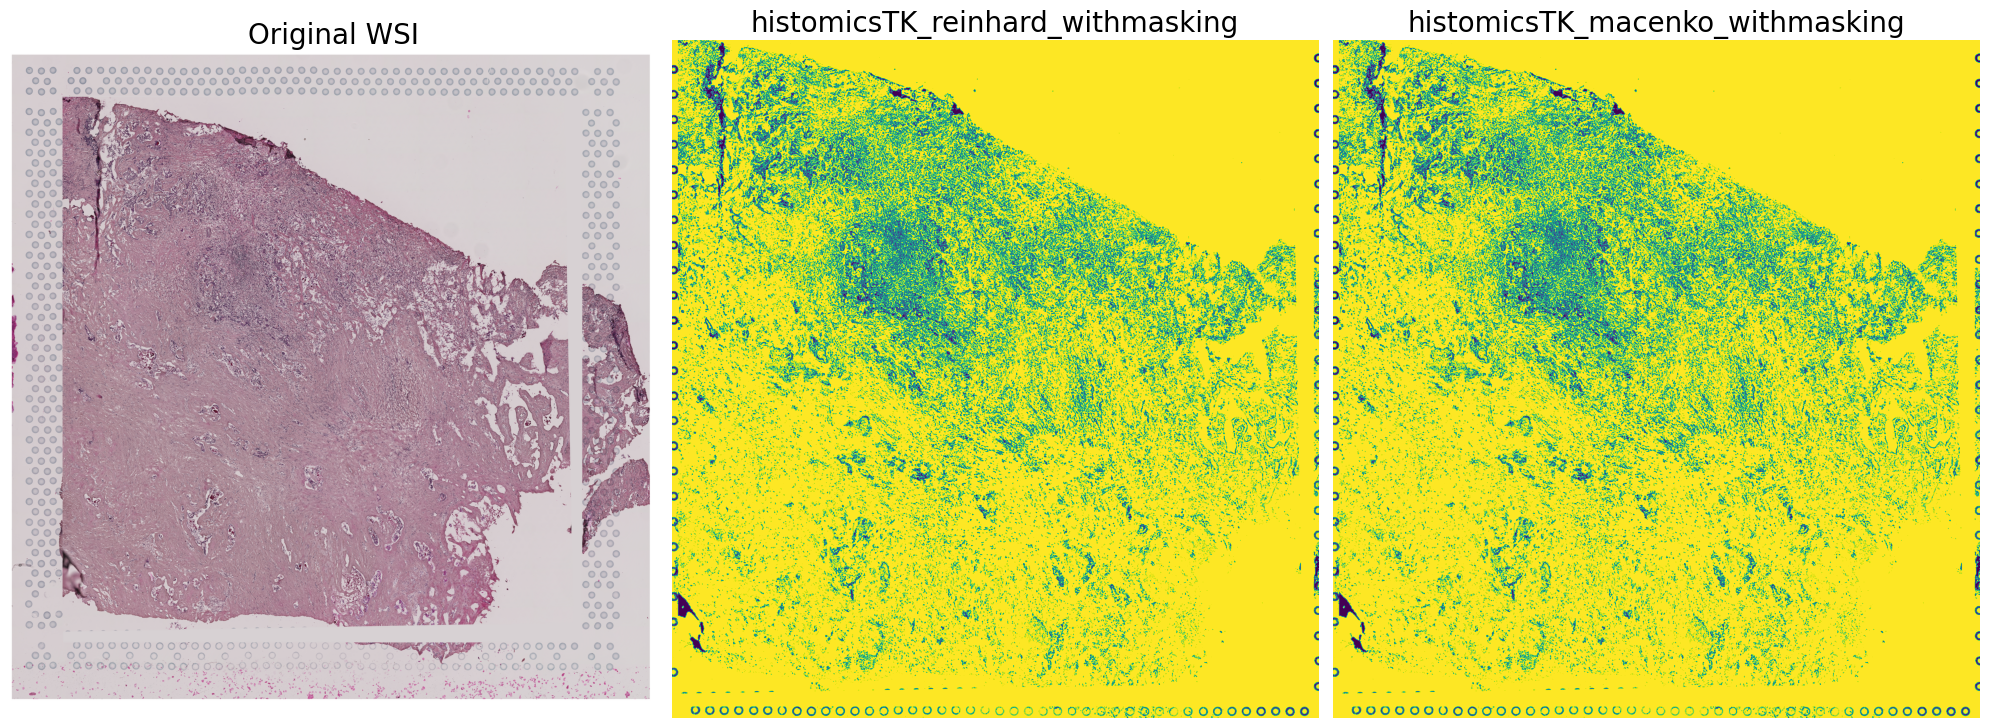

In [13]:
# If we want to plot only the WSI normalised with the image `reference_full.jpeg`
TARGET_IS_REFERENCE = "target_is_reference_full"
temp_resized_masks_reference = []
for i in all_resized_masks:
    parts = i.split("/")
    if len(parts) > 5 and parts[5] == TARGET_IS_REFERENCE:
        temp_resized_masks_reference.append(i)

# adding the path to the original image
temp_resized_masks_reference.insert(0, all_resized_wsis[0])

# Number of rows and columns for the grid
n_rows, n_cols = 1, len(temp_resized_masks_reference)

# Create a figure, axes amd font size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_rows*20, n_cols*20))
font = 20

# Plot each image
for i, ax in enumerate(axes.flat):
    if i < len(temp_resized_masks_reference):
        
        if "original" in os.path.basename(temp_resized_masks_reference[i]): 
            # case 2: original WSI
            img = mpimg.imread(temp_resized_masks_reference[i])
            ax.imshow(img) 
            ax.set_title(f"Original WSI", fontsize=font)
            
        else:
            # case 3: normalised images: title after normalisation method
            title = temp_resized_masks_reference[i].split("/")[-3]
            img = mpimg.imread(temp_resized_masks_reference[i])
            ax.imshow(img)
            ax.set_title(f"{title}", fontsize=font) 
    ax.axis("off")  # Hide the axis

# Adjust layout
plt.tight_layout()
fig.savefig("./figures/comparison_of_masks_reference_full.pdf", format="pdf", bbox_inches="tight")
fig.savefig("./figures/comparison_of_masks_reference_full.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


Obviously, they are the same.

---
# Conclusion

**So, from now on, we are going to refer to the *normalised WSIs* as the Macenko's normalised ones, as the other methods showed to not compute correctly (Reinhard's) or didn't work at all (all the others).**

---
**Saving the environment requirements**

In [14]:
# Save package versions to a .txt file
with open("requirements_for_visualisation_env.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)